In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/plantsds/coarse-and-fine-grained-ner-dataset.csv
/kaggle/input/plantsds/plant-species-names-ner-dataset.csv


**Model 1 : Vanilla Rnn**

In [13]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
import numpy as np

data_path = "/kaggle/input/plantsds/coarse-and-fine-grained-ner-dataset.csv"
data = pd.read_csv(data_path)

texts = data['Text'].tolist()
annotations = data['Fine-grained Annotation'].apply(eval).tolist()

word_to_id = {}
id_to_word = {}
idx = 1 
for text in texts:
    tokens = word_tokenize(text)
    for token in tokens:
        if token not in word_to_id:
            word_to_id[token] = idx
            id_to_word[idx] = token
            idx += 1

unique_labels = set(entity for ann in annotations for _, _, entity in ann)
label_to_id = {label: idx + 1 for idx, label in enumerate(unique_labels)} 
label_to_id['O'] = 0 

def encode_annotations(text, annotations, max_length=128):
    tokens = word_tokenize(text)
    token_ids = [word_to_id[token] for token in tokens]
    labels = [0] * len(tokens) 

    for start, end, label in annotations:
        for idx, token in enumerate(tokens):
            token_start = text.find(token)
            token_end = token_start + len(token)
            if token_start >= start and token_end <= end:
                labels[idx] = label_to_id[label]

    token_ids = token_ids[:max_length] + [0] * (max_length - len(token_ids))
    labels = labels[:max_length] + [0] * (max_length - len(labels))

    return token_ids, labels

max_length = 128
encoded_data = [encode_annotations(text, ann, max_length) for text, ann in zip(texts, annotations)]

train_data, test_data = train_test_split(encoded_data, test_size=0.2, random_state=42)

class PlantNERDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tokens, labels = self.data[idx]
        return torch.tensor(tokens), torch.tensor(labels)

train_dataset = PlantNERDataset(train_data)
test_dataset = PlantNERDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

import torch.nn as nn

class VanillaRNNNER(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(VanillaRNNNER, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        embedded = self.embedding(x) 
        output, _ = self.rnn(embedded)  
        logits = self.fc(output) 
        return logits

vocab_size = len(word_to_id) + 1  
embedding_dim = 64
hidden_dim = 128
num_classes = len(label_to_id)

model = VanillaRNNNER(vocab_size, embedding_dim, hidden_dim, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for tokens, labels in train_loader:
        tokens, labels = tokens.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(tokens) 

        outputs = outputs.view(-1, num_classes) 
        labels = labels.view(-1) 

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

Epoch [1/10], Loss: 1.5541
Epoch [2/10], Loss: 0.9872
Epoch [3/10], Loss: 0.7607
Epoch [4/10], Loss: 0.6208
Epoch [5/10], Loss: 0.5203
Epoch [6/10], Loss: 0.4388
Epoch [7/10], Loss: 0.3848
Epoch [8/10], Loss: 0.3335
Epoch [9/10], Loss: 0.2957
Epoch [10/10], Loss: 0.2627


In [14]:
import json

model_save_path = "model1.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model state dictionary saved to {model_save_path}")

word_to_id_save_path = "word_to_id1.json"
with open(word_to_id_save_path, "w") as f:
    json.dump(word_to_id, f)
print(f"Word-to-ID mapping saved to {word_to_id_save_path}")

label_to_id_save_path = "label_to_id1.json"
with open(label_to_id_save_path, "w") as f:
    json.dump(label_to_id, f)
print(f"Label-to-ID mapping saved to {label_to_id_save_path}")

Model state dictionary saved to model1.pth
Word-to-ID mapping saved to word_to_id1.json
Label-to-ID mapping saved to label_to_id1.json


In [15]:
import json
import torch
from nltk.tokenize import word_tokenize

def predict(model, text, word_to_id, id_to_word, label_to_id, id_to_label, max_length=128):
    model.eval()
    tokens = word_tokenize(text)
    
    token_ids = [word_to_id.get(token, 0) for token in tokens] 
    token_ids = token_ids[:max_length] + [0] * (max_length - len(token_ids)) 
    
    token_tensor = torch.tensor(token_ids).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(token_tensor) 
        predictions = torch.argmax(outputs, dim=-1).squeeze(0).tolist()

    predicted_labels = [id_to_label[label_id] for label_id in predictions[:len(tokens)]]

    return list(zip(tokens, predicted_labels))

id_to_label = {idx: label for label, idx in label_to_id.items()}

example_text = "arbustes avec petites feuilles opposées et nervure proéminente."

predictions = predict(model, example_text, word_to_id, id_to_word, label_to_id, id_to_label, max_length=128)

print("Predictions:")
for token, label in predictions:
    print(f"{token}: {label}")

Predictions:
arbustes: ORGANE
avec: DISPOSITION
petites: DESCRIPTEUR
feuilles: ORGANE
opposées: DISPOSITION
et: DESCRIPTEUR
nervure: ORGANE
proéminente: DESCRIPTEUR
.: DESCRIPTEUR


In [16]:
model_save_path = "vanilla_rnn_ner_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to vanilla_rnn_ner_model.pth


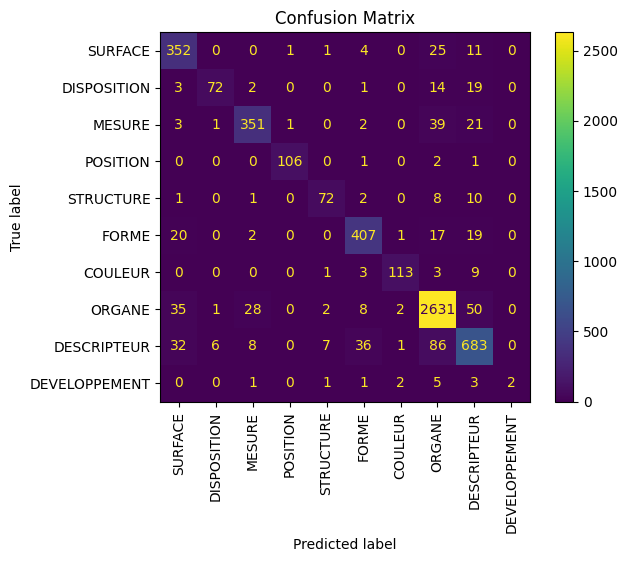

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_and_generate_confusion_matrix(model, data_loader, id_to_label):
    """
    Evaluate the model on the test dataset and generate a confusion matrix.

    Args:
        model (nn.Module): Trained model.
        data_loader (DataLoader): DataLoader for the test dataset.
        id_to_label (dict): Mapping from label IDs to label names.

    Returns:
        None
    """
    model.eval()
    all_true_labels = []
    all_predicted_labels = []

    with torch.no_grad():
        for tokens, labels in data_loader:
            tokens, labels = tokens.to(device), labels.to(device)
            outputs = model(tokens)

            predictions = torch.argmax(outputs, dim=-1)

            for pred_seq, true_seq in zip(predictions, labels):
                for pred_label, true_label in zip(pred_seq, true_seq):
                    if true_label.item() != 0:
                        all_predicted_labels.append(pred_label.item())
                        all_true_labels.append(true_label.item())

    unique_labels = sorted(set(all_true_labels) | set(all_predicted_labels))
    cm = confusion_matrix(all_true_labels, all_predicted_labels, labels=unique_labels)

    label_names = [id_to_label[label] for label in unique_labels]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(include_values=True, cmap='viridis', xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

evaluate_and_generate_confusion_matrix(model, test_loader, id_to_label)

**BiLSTM**

In [18]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import numpy as np
import json

data_path = "/kaggle/input/plantsds/coarse-and-fine-grained-ner-dataset.csv"
data = pd.read_csv(data_path)

texts = data['Text'].tolist()
annotations = data['Fine-grained Annotation'].apply(eval).tolist()

word_to_id = {}
id_to_word = {}
idx = 1 
for text in texts:
    tokens = word_tokenize(text)
    for token in tokens:
        if token not in word_to_id:
            word_to_id[token] = idx
            id_to_word[idx] = token
            idx += 1

unique_labels = set(entity for ann in annotations for _, _, entity in ann)
label_to_id = {label: idx + 1 for idx, label in enumerate(unique_labels)} 
label_to_id['O'] = 0 

def encode_annotations(text, annotations, max_length=128):
    tokens = word_tokenize(text)
    token_ids = [word_to_id.get(token, 0) for token in tokens]  
    labels = [0] * len(tokens) 

    for start, end, label in annotations:
        for idx, token in enumerate(tokens):
            token_start = text.find(token)
            token_end = token_start + len(token)
            if token_start >= start and token_end <= end:
                labels[idx] = label_to_id[label]

    token_ids = token_ids[:max_length] + [0] * (max_length - len(token_ids))
    labels = labels[:max_length] + [0] * (max_length - len(labels))

    return token_ids, labels

max_length = 128
encoded_data = [encode_annotations(text, ann, max_length) for text, ann in zip(texts, annotations)]

# Train-test split
train_data, test_data = train_test_split(encoded_data, test_size=0.2, random_state=42)

class PlantNERDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tokens, labels = self.data[idx]
        return torch.tensor(tokens), torch.tensor(labels)

train_dataset = PlantNERDataset(train_data)
test_dataset = PlantNERDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

import torch.nn as nn

class BiLSTMNER(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(BiLSTMNER, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        embedded = self.embedding(x) 
        output, _ = self.lstm(embedded)  
        output = self.dropout(output)
        logits = self.fc(output) 
        return logits

vocab_size = len(word_to_id) + 1  
embedding_dim = 64
hidden_dim = 128
num_classes = len(label_to_id)

model = BiLSTMNER(vocab_size, embedding_dim, hidden_dim, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for tokens, labels in train_loader:
        tokens, labels = tokens.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(tokens) 

        outputs = outputs.view(-1, num_classes) 
        labels = labels.view(-1) 

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

model_save_path = "bilstm_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

word_to_id_save_path = "word_to_id.json"
with open(word_to_id_save_path, "w") as f:
    json.dump(word_to_id, f)
print(f"Word-to-ID mapping saved to {word_to_id_save_path}")

label_to_id_save_path = "label_to_id.json"
with open(label_to_id_save_path, "w") as f:
    json.dump(label_to_id, f)
print(f"Label-to-ID mapping saved to {label_to_id_save_path}")

def predict(model, text, word_to_id, id_to_label, max_length=128):
    model.eval()  
    tokens = word_tokenize(text)

    token_ids = [word_to_id.get(token, 0) for token in tokens]  
    token_ids = token_ids[:max_length] + [0] * (max_length - len(token_ids))  

    token_tensor = torch.tensor(token_ids).unsqueeze(0).to(device) 

    with torch.no_grad():
        outputs = model(token_tensor)
        predictions = torch.argmax(outputs, dim=-1).squeeze(0).tolist() 

    predicted_labels = [id_to_label[label_id] for label_id in predictions[:len(tokens)]]

    return list(zip(tokens, predicted_labels))

id_to_label = {idx: label for label, idx in label_to_id.items()}

Epoch [1/10], Loss: 1.6755
Epoch [2/10], Loss: 1.0271
Epoch [3/10], Loss: 0.7245
Epoch [4/10], Loss: 0.5635
Epoch [5/10], Loss: 0.4623
Epoch [6/10], Loss: 0.3887
Epoch [7/10], Loss: 0.3358
Epoch [8/10], Loss: 0.2940
Epoch [9/10], Loss: 0.2565
Epoch [10/10], Loss: 0.2306
Model saved to bilstm_model.pth
Word-to-ID mapping saved to word_to_id.json
Label-to-ID mapping saved to label_to_id.json


In [19]:
model_save_path = "bilstm_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to bilstm_model.pth


In [20]:
example_text = "arbustes avec petites feuilles opposées et nervure proéminente."

predictions = predict(model, example_text, word_to_id, id_to_label, max_length=128)

print("Predictions:")
for token, label in predictions:
    print(f"{token}: {label}")

Predictions:
arbustes: ORGANE
avec: DESCRIPTEUR
petites: DESCRIPTEUR
feuilles: ORGANE
opposées: DISPOSITION
et: DESCRIPTEUR
nervure: ORGANE
proéminente: DESCRIPTEUR
.: DESCRIPTEUR


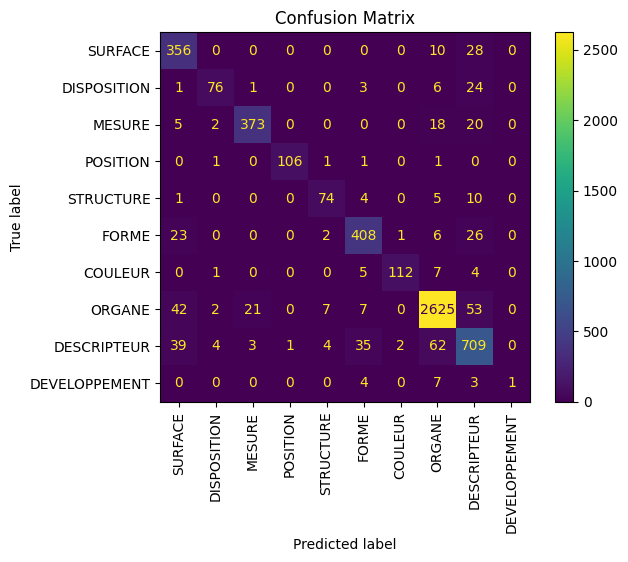

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_and_generate_confusion_matrix(model, data_loader, id_to_label):
    """
    Evaluate the model and generate a confusion matrix.

    Args:
        model (nn.Module): Trained model.
        data_loader (DataLoader): DataLoader for the test dataset.
        id_to_label (dict): Mapping from label IDs to label names.

    Returns:
        None
    """
    model.eval()
    all_true_labels = []
    all_predicted_labels = []

    with torch.no_grad():
        for tokens, labels in data_loader:
            tokens, labels = tokens.to(device), labels.to(device)
            outputs = model(tokens)

            # Get predictions
            predictions = torch.argmax(outputs, dim=-1)

            # Flatten predictions and labels, ignoring padding (label 0)
            for pred_seq, true_seq in zip(predictions, labels):
                for pred_label, true_label in zip(pred_seq, true_seq):
                    if true_label.item() != 0:  # Ignore padding
                        all_predicted_labels.append(pred_label.item())
                        all_true_labels.append(true_label.item())

    # Convert labels back to names for display
    unique_labels = sorted(list(set(all_true_labels) | set(all_predicted_labels)))
    label_names = [id_to_label[label] for label in unique_labels]

    # Generate confusion matrix
    cm = confusion_matrix(all_true_labels, all_predicted_labels, labels=unique_labels)

    # Display confusion matrix as a heatmap
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(include_values=True, cmap='viridis', xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate the model and generate confusion matrix
evaluate_and_generate_confusion_matrix(model, test_loader, id_to_label)


**GRU**

In [22]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import json
import torch.nn as nn

data_path = "/kaggle/input/plantsds/coarse-and-fine-grained-ner-dataset.csv"
data = pd.read_csv(data_path)

texts = data['Text'].tolist()
annotations = data['Fine-grained Annotation'].apply(eval).tolist()

word_to_id = {}
id_to_word = {}
idx = 1 
for text in texts:
    tokens = word_tokenize(text)
    for token in tokens:
        if token not in word_to_id:
            word_to_id[token] = idx
            id_to_word[idx] = token
            idx += 1

unique_labels = set(entity for ann in annotations for _, _, entity in ann)
label_to_id = {label: idx + 1 for idx, label in enumerate(unique_labels)} 
label_to_id['O'] = 0

def encode_annotations(text, annotations, max_length=128):
    tokens = word_tokenize(text)
    token_ids = [word_to_id.get(token, 0) for token in tokens]
    labels = [0] * len(tokens) 

    for start, end, label in annotations:
        for idx, token in enumerate(tokens):
            token_start = text.find(token)
            token_end = token_start + len(token)
            if token_start >= start and token_end <= end:
                labels[idx] = label_to_id[label]

    token_ids = token_ids[:max_length] + [0] * (max_length - len(token_ids))
    labels = labels[:max_length] + [0] * (max_length - len(labels))

    return token_ids, labels

max_length = 128
encoded_data = [encode_annotations(text, ann, max_length) for text, ann in zip(texts, annotations)]

train_data, test_data = train_test_split(encoded_data, test_size=0.2, random_state=42)

class PlantNERDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tokens, labels = self.data[idx]
        return torch.tensor(tokens), torch.tensor(labels)

train_dataset = PlantNERDataset(train_data)
test_dataset = PlantNERDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

class GRUNER(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(GRUNER, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        embedded = self.embedding(x) 
        gru_output, _ = self.gru(embedded)  
        gru_output = self.dropout(gru_output)
        logits = self.fc(gru_output) 
        return logits

vocab_size = len(word_to_id) + 1  
embedding_dim = 64
hidden_dim = 128
num_classes = len(label_to_id)

model = GRUNER(vocab_size, embedding_dim, hidden_dim, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for tokens, labels in train_loader:
        tokens, labels = tokens.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(tokens) 

        outputs = outputs.view(-1, num_classes) 
        labels = labels.view(-1) 

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

model_save_path = "gru_ner_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

word_to_id_save_path = "word_to_id.json"
label_to_id_save_path = "label_to_id.json"

with open(word_to_id_save_path, "w") as f:
    json.dump(word_to_id, f)
print(f"Word-to-ID mapping saved to {word_to_id_save_path}")

with open(label_to_id_save_path, "w") as f:
    json.dump(label_to_id, f)
print(f"Label-to-ID mapping saved to {label_to_id_save_path}")

def predict(model, text, word_to_id, id_to_label, max_length=128):
    model.eval() 
    tokens = word_tokenize(text)

    token_ids = [word_to_id.get(token, 0) for token in tokens] 
    token_ids = token_ids[:max_length] + [0] * (max_length - len(token_ids)) 

    token_tensor = torch.tensor(token_ids).unsqueeze(0).to(device) 

    with torch.no_grad():
        outputs = model(token_tensor)  
        predictions = torch.argmax(outputs, dim=-1).squeeze(0).tolist()

    predicted_labels = [id_to_label[label_id] for label_id in predictions[:len(tokens)]]

    return list(zip(tokens, predicted_labels))

id_to_label = {idx: label for label, idx in label_to_id.items()}

example_text = "arbustes avec petites feuilles opposées et nervure proéminente."

predictions = predict(model, example_text, word_to_id, id_to_label, max_length=128)

print("Predictions:")
for token, label in predictions:
    print(f"{token}: {label}")

Epoch [1/10], Loss: 1.5672
Epoch [2/10], Loss: 0.9065
Epoch [3/10], Loss: 0.6529
Epoch [4/10], Loss: 0.5225
Epoch [5/10], Loss: 0.4363
Epoch [6/10], Loss: 0.3739
Epoch [7/10], Loss: 0.3239
Epoch [8/10], Loss: 0.2854
Epoch [9/10], Loss: 0.2492
Epoch [10/10], Loss: 0.2261
Model saved to gru_ner_model.pth
Word-to-ID mapping saved to word_to_id.json
Label-to-ID mapping saved to label_to_id.json
Predictions:
arbustes: ORGANE
avec: COULEUR
petites: DESCRIPTEUR
feuilles: ORGANE
opposées: DISPOSITION
et: DESCRIPTEUR
nervure: ORGANE
proéminente: DESCRIPTEUR
.: DESCRIPTEUR


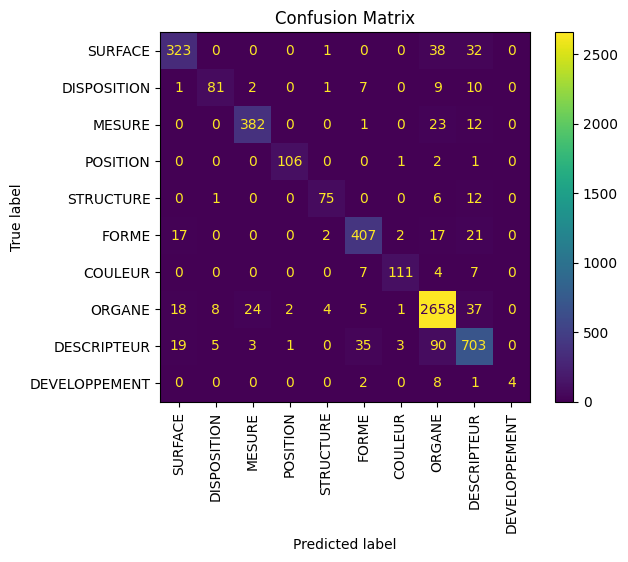

In [23]:
def evaluate_and_generate_confusion_matrix(model, data_loader, id_to_label):
    """
    Evaluate the model on the test dataset and generate a confusion matrix.

    Args:
        model (nn.Module): Trained model.
        data_loader (DataLoader): DataLoader for the test dataset.
        id_to_label (dict): Mapping from label IDs to label names.

    Returns:
        None
    """
    model.eval()
    all_true_labels = []
    all_predicted_labels = []

    with torch.no_grad():
        for tokens, labels in data_loader:
            tokens, labels = tokens.to(device), labels.to(device)
            outputs = model(tokens)

            predictions = torch.argmax(outputs, dim=-1)

            for pred_seq, true_seq in zip(predictions, labels):
                for pred_label, true_label in zip(pred_seq, true_seq):
                    if true_label.item() != 0:
                        all_predicted_labels.append(pred_label.item())
                        all_true_labels.append(true_label.item())

    unique_labels = sorted(set(all_true_labels) | set(all_predicted_labels))
    cm = confusion_matrix(all_true_labels, all_predicted_labels, labels=unique_labels)

    label_names = [id_to_label[label] for label in unique_labels]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(include_values=True, cmap='viridis', xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

evaluate_and_generate_confusion_matrix(model, test_loader, id_to_label)

**Comparing the three models**

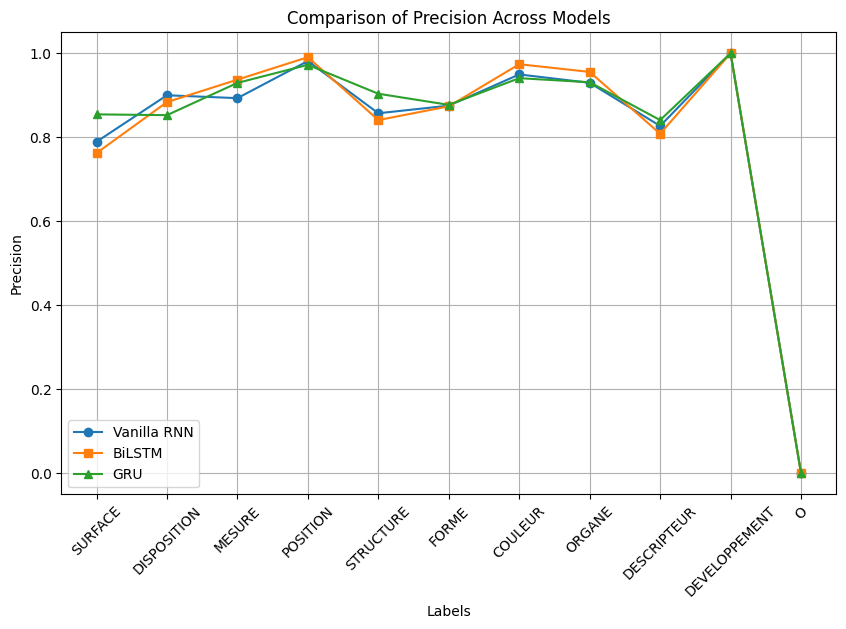

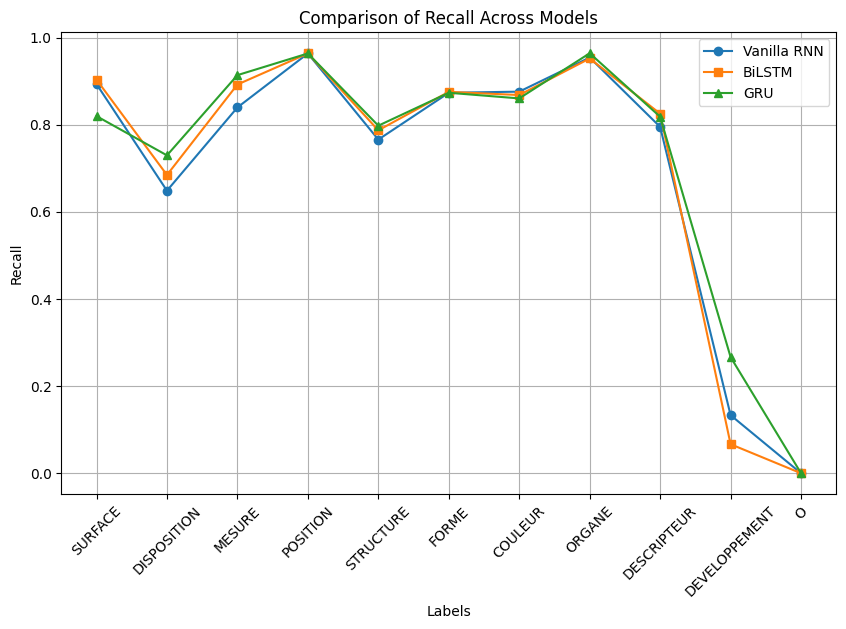

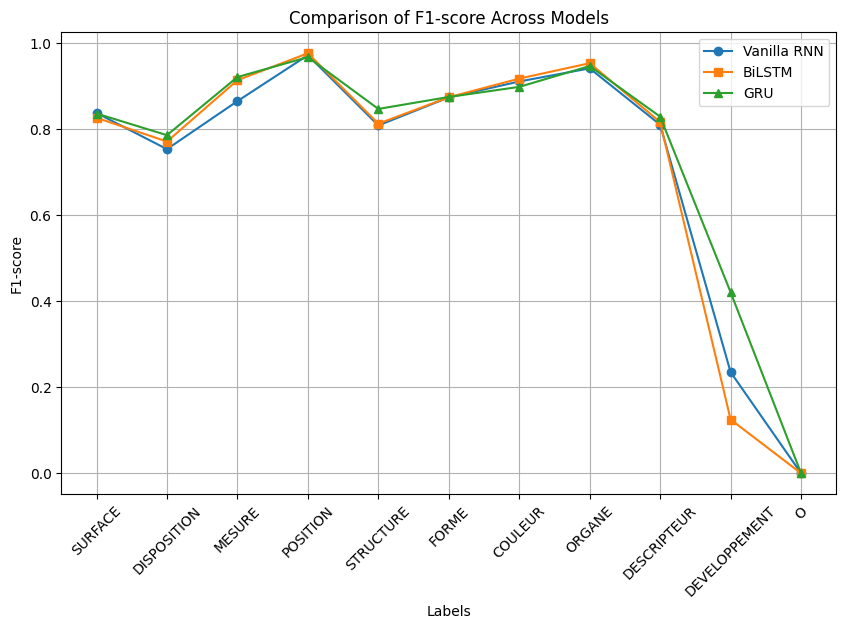

In [31]:
from sklearn.metrics import classification_report

def evaluate_model(model, data_loader, id_to_label):
    """
    Evaluate the model and generate classification metrics.
    
    Args:
        model (nn.Module): The trained model.
        data_loader (DataLoader): DataLoader for the test dataset.
        id_to_label (dict): Mapping of label IDs to label names.
    
    Returns:
        dict: Classification report.
    """
    model.eval()
    all_true_labels = []
    all_predicted_labels = []
    
    with torch.no_grad():
        for tokens, labels in data_loader:
            tokens, labels = tokens.to(device), labels.to(device)
            outputs = model(tokens)
            predictions = torch.argmax(outputs, dim=-1)

            for pred_seq, true_seq in zip(predictions, labels):
                for pred_label, true_label in zip(pred_seq, true_seq):
                    if true_label.item() != 0:  # Ignore padding
                        all_predicted_labels.append(pred_label.item())
                        all_true_labels.append(true_label.item())
    
    report = classification_report(
        all_true_labels,
        all_predicted_labels,
        labels=list(id_to_label.keys()),
        target_names=list(id_to_label.values()),
        zero_division=0,
        output_dict=True
    )
    return report

vanilla_rnn_model = VanillaRNNNER(vocab_size, embedding_dim, hidden_dim, num_classes)
vanilla_rnn_model.load_state_dict(torch.load("model1.pth", weights_only=True))
vanilla_rnn_model.to(device)

class BiLSTMNER(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(BiLSTMNER, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        embedded = self.embedding(x) 
        lstm_output, _ = self.lstm(embedded)  
        lstm_output = self.dropout(lstm_output)
        logits = self.fc(lstm_output) 
        return logits

bilstm_model = BiLSTMNER(vocab_size, embedding_dim, hidden_dim, num_classes)
bilstm_model.load_state_dict(torch.load("bilstm_model.pth", weights_only=True))
bilstm_model.to(device)

gru_model = GRUNER(vocab_size, embedding_dim, hidden_dim, num_classes)
gru_model.load_state_dict(torch.load("gru_ner_model.pth", weights_only=True))
gru_model.to(device)

vanilla_rnn_report = evaluate_model(vanilla_rnn_model, test_loader, id_to_label)
bilstm_report = evaluate_model(bilstm_model, test_loader, id_to_label)
gru_report = evaluate_model(gru_model, test_loader, id_to_label)

import matplotlib.pyplot as plt

def compare_metrics(vanilla_rnn_report, bilstm_report, gru_report):
    """
    Compare the precision, recall, and F1-score of three models.
    """
    metrics = ['precision', 'recall', 'f1-score']
    
    labels = list(vanilla_rnn_report.keys())[:-3]
    
    vanilla_scores = {metric: [vanilla_rnn_report[label][metric] for label in labels] for metric in metrics}
    bilstm_scores = {metric: [bilstm_report[label][metric] for label in labels] for metric in metrics}
    gru_scores = {metric: [gru_report[label][metric] for label in labels] for metric in metrics}

    for metric in metrics:
        plt.figure(figsize=(10, 6))
        plt.plot(labels, vanilla_scores[metric], marker='o', label='Vanilla RNN')
        plt.plot(labels, bilstm_scores[metric], marker='s', label='BiLSTM')
        plt.plot(labels, gru_scores[metric], marker='^', label='GRU')
        plt.title(f"Comparison of {metric.capitalize()} Across Models")
        plt.xlabel("Labels")
        plt.ylabel(metric.capitalize())
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid()
        plt.show()


compare_metrics(vanilla_rnn_report, bilstm_report, gru_report)


**Testing the models**

In [45]:
def predict_with_prepositions_as_o(model, text, word_to_id, id_to_label, max_length=128):
    """
    Predict labels for input text using the given model.
    Automatically assigns 'O' to prepositions and unknown words.
    """
    model.eval()
    tokens = word_tokenize(text)

    prepositions = {"avec", "et", "à", "avec", "de", "depuis", "dès", "en", "jusque", "malgré", "outre", "par", "parmi", "pour", "sans", "sauf", "selon", "vers", "le", "la", "un", "une", "les", "des"}

    token_ids = [word_to_id.get(token, 0) for token in tokens]
    token_ids = token_ids[:max_length] + [0] * (max_length - len(token_ids)) 

    token_tensor = torch.tensor(token_ids).unsqueeze(0).to(device) 

    with torch.no_grad():
        outputs = model(token_tensor)
        predictions = torch.argmax(outputs, dim=-1).squeeze(0).tolist()

    predicted_labels = []
    for token, label_id in zip(tokens, predictions[:len(tokens)]):
        if token in prepositions:
            predicted_labels.append('O')
        elif token not in word_to_id: 
            predicted_labels.append('O')
        else:
            predicted_labels.append(id_to_label.get(label_id, 'O')) 

    return list(zip(tokens, predicted_labels))

example_text = "une feuille verte et ovale"

vanilla_rnn_predictions = predict_with_prepositions_as_o(vanilla_rnn_model, example_text, word_to_id, id_to_label)

bilstm_predictions = predict_with_prepositions_as_o(bilstm_model, example_text, word_to_id, id_to_label)

gru_predictions = predict_with_prepositions_as_o(gru_model, example_text, word_to_id, id_to_label)

print("\nVanilla RNN Predictions:")
for token, label in vanilla_rnn_predictions:
    print(f"{token}: {label}")

print("\nBiLSTM Predictions:")
for token, label in bilstm_predictions:
    print(f"{token}: {label}")

print("\nGRU Predictions:")
for token, label in gru_predictions:
    print(f"{token}: {label}")



Vanilla RNN Predictions:
une: O
feuille: ORGANE
verte: COULEUR
et: O
ovale: FORME

BiLSTM Predictions:
une: O
feuille: ORGANE
verte: COULEUR
et: O
ovale: FORME

GRU Predictions:
une: O
feuille: ORGANE
verte: COULEUR
et: O
ovale: FORME
